## ToDo List
- [x] Checar se formato de datas conferem.
- [x] Remover UGs sem liberação OC
- [x] Considerar coluna montagem. Onde estiver vazio, pegar valor de Torres para EOL, no skate.
- [x] Calcular tempos de construção por marco: (IO_realizado - realizado), (CC_realizado - realizado) ...etc  (ordem:IO,CC,ME,OT)
- [x] Calcular atraso da operação comercial (realizado - outorgado)
- [x] Calcular média e std do tempo de construção.
- [x] Calcular data dos marcos medios (outorgado - tempo_medio_de_construcao) por fonte.
- [x] Calcular atrasos com base nos marcos medios
- [x] Calcular media e std dos atrasos. 
- [x] Normalizar os atrasos calculados (atraso - atraso_medio)/std
- [x] Construir matriz de correlação de Pearson
- [x] Calcular os coeficientes para regressão linear
- [x] Para UHE pegar todas UGs, para as demais pegar a primeira UG apenas
- [ ] Separar um cojunto aleatório para teste
- [x] Comparar pegando primeira UG e media por grupo
- [x] Separar curvas para ACR e ACL


## Resumo do script
- Carrega arquivo com ambos BDs => bd_combined
- Muda-se o ID das UHEs para que cada UG seja tratada como uma usina diferente => bd_combined
- Remove-se as linhas cujas colunas DatUGInicioOpComerOutorgado e DatLiberOpComerRealizado não sejam nulas => bd_combined
- Calcula-se o tempo por fase por UG: bd_combined["DatLiberOpComerRealizado"] - bd_combined[Marco_realizado] => tempo_fase_por_UG
- Remove incosistências => tempo_fase_por_UG_filtered
- Obtem-se os tempos de cada marco para cada usina considerando a primeira UG a entrar em operação comercial => tempo_construcao_por_usina
- Calcula-se outliers e tempo medio por fase e geracao já desconsiderando outliers. Os outliers são identificados como aquelas usinas cujo
tempo da fase da usina é muito superior a media do tempo da fase para o tipo de geração da usina  => dict_tempo_fase_mean_std
- Calcula-se o marco medio de cada fase de cada usina fazendo: DatUGInicioOpComerOutorgado - tempo_fase_medio = marco_medio_usina
- Calcula-se o atraso de cada usina com base no marco medio: marco - marco_medio_usina

In [30]:
import pandas as pd
import numpy as np
import re
import pyodbc
from pprint import pprint
import matplotlib.pyplot as plt
from scipy import stats
from itertools import combinations,chain
import warnings

In [2]:
warnings.filterwarnings("default") # defaul , error, ignore 

In [3]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

In [4]:
bd_combined = pd.read_parquet("bd_combined.gzip")

#### Transforma coluna IdeUsinaOutorga das UHEs para que cada UG possua esse campo diferente. Por exemplo as UGs da usina 12 serão 12_0, 12_1...

In [5]:
bd_combined.index.name = "idx"
bd_combined.IdeUsinaOutorga = bd_combined.IdeUsinaOutorga.astype(str)
mask_UHE_duplicate = (bd_combined.SigTipoGeracao == "UHE") & (bd_combined.IdeUsinaOutorga.duplicated(keep=False))
#bd_combined.loc[mask_UHE_duplicate,"IdeUsinaOutorga"] = bd_combined.loc[mask_UHE_duplicate,"IdeUsinaOutorga"] +"_"+ bd_combined.loc[mask_UHE_duplicate].groupby("IdeUsinaOutorga").cumcount().astype(str)
bd_combined.sample(15)

,IdeUsinaOutorga,DatInicioOpTesteOutorgada,DatUGInicioOpComerOutorgado,DatLiberacaoSFGTeste,DatLiberOpComerRealizado,UFUsina,VlrPotenciaOutorgada,DatInicioObraOutorgado,DatInicioObraRealizado,DatConcretagemOutorgado,DatConcretagemRealizado,DatMontagemOutorgado,DatMontagemRealizado,Torres_Outorga,Torres_Real,DatEnchimentoOutorgado,DatEnchimentoRealizado,DatSisTransmissaoOutorgado,DatSisTransmissaoRealizado,DscComercializacaoEnergia,SigTipoGeracao,Quant_UG,Pot_UG,origem,DatOutorgaUsina,DatInicioSuprimento
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
3487,35211,2022-12-05,2023-01-01,2021-08-03,2021-12-01,RN,29400.00,2021-10-07,2020-10-15,2022-03-03,2021-02-15,2022-06-15,2021-06-15,None,None,NaT,NaT,2022-03-03,2020-05-15,ACR,EOL,7,29400.00,skate,2018-05-29,2023-01-01
4722,44464,2023-11-30,2024-01-01,NaT,NaT,MG,48217.00,2022-07-01,NaT,NaT,NaT,2022-09-15,NaT,None,None,NaT,NaT,NaT,NaT,Fora do ACR,UFV,27,48216.60,skate,2021-08-03,None
1287,30870,2013-12-02,2014-01-01,2015-03-05,2015-06-27,RN,29.70,NaT,2013-01-01,NaT,2014-07-15,NaT,2015-03-13,None,2015-03-13,NaT,NaT,NaT,2015-03-13,Fora do ACR,EOL,11,29.70,bdworgs,None,None
1625,31611,2017-12-26,2018-01-01,2018-05-25,2018-06-29,CE,16.80,2017-02-25,2016-10-15,2017-06-21,2017-01-15,2017-09-21,NaT,2017-09-21,2017-10-16,NaT,NaT,2017-04-10,2017-02-28,ACR,EOL,1,2.10,bdworgs,None,None
1835,32297,2015-10-12,2015-10-12,2016-06-11,2016-07-14,RO,9.20,2015-07-15,2016-04-01,NaT,NaT,2015-10-12,2016-04-15,None,None,NaT,NaT,NaT,2015-11-30,ACR,UTE,9,9.20,bdworgs,None,None
1002,30387,2013-03-01,2013-04-01,2015-03-06,2015-07-23,SC,2.05,2011-03-03,2011-05-03,2011-09-01,2011-05-03,2012-09-01,2013-09-30,None,None,2013-01-01,NaT,2012-09-01,NaT,Fora do ACR,CGH,2,2.05,bdworgs,None,None
3439,35074,2019-04-15,2020-03-01,NaT,NaT,CE,9000.00,2017-01-04,2020-01-07,2017-03-16,2020-01-07,2017-08-31,2020-05-19,None,None,2018-10-29,2018-10-29,2018-01-04,2020-06-06,ACR,PCH,1,4500.00,skate,2017-04-19,2020-03-01
550,29458,2018-06-06,2012-01-31,2018-06-06,2018-08-10,MG,333.70,2008-04-30,2007-03-01,2008-04-30,2008-12-01,NaT,NaT,None,None,NaT,2013-02-23,NaT,2010-03-02,ACR,UHE,1,14.00,bdworgs,None,None
4535,40778,2022-10-30,2022-12-31,NaT,NaT,BA,42000.00,2021-08-30,2022-03-10,2021-12-30,NaT,2022-05-30,NaT,None,None,NaT,NaT,NaT,2022-02-15,Fora do ACR,EOL,10,42000.00,skate,2021-04-06,None


#### Remove linhas cujas colunas DatUGInicioOpComerOutorgado e DatLiberOpComerRealizado não sejam nulas

In [6]:
mask_OC_notna = bd_combined.DatUGInicioOpComerOutorgado.notna() & bd_combined.DatLiberOpComerRealizado.notna()
bd_combined = bd_combined[mask_OC_notna].copy()

In [7]:
lista_colunas_basic_info = ["IdeUsinaOutorga","SigTipoGeracao","origem","DscComercializacaoEnergia"]
lista_colunas_datas_usadas = ["DatInicioObraRealizado","DatConcretagemRealizado","DatMontagemRealizado","DatLiberacaoSFGTeste","DatLiberOpComerRealizado",'DatUGInicioOpComerOutorgado']
calc = bd_combined[lista_colunas_basic_info + lista_colunas_datas_usadas].copy()

#### Cria dicionário com o tempo de cada marco a até a DatLiberOpComerRealizado por cada UG

In [8]:
dict_fase_marco = {
    "IO_OC" : "DatInicioObraRealizado",
    "CC_OC" : "DatConcretagemRealizado",
    "ME_OC" : "DatMontagemRealizado",
    "OT_OC" : "DatLiberacaoSFGTeste"
}

dict_marco_nome = {v: k for k, v in dict_fase_marco.items()}

#### Calcula o tempo por fase por UG

In [9]:
lista_colunas_tempo_fase = []
tempo_fase_por_UG = bd_combined[lista_colunas_basic_info + ["DatLiberOpComerRealizado"]].copy(deep=True) #[["IdeUsinaOutorga","SigTipoGeracao","origem"]]
for nome,marco in dict_fase_marco.items():
    tempo_fase_por_UG[nome] = bd_combined["DatLiberOpComerRealizado"]-  bd_combined[marco]
    calc[nome] = tempo_fase_por_UG[nome]
    lista_colunas_tempo_fase.append(nome)
tempo_fase_por_UG["Atraso"]  =  bd_combined["DatLiberOpComerRealizado"]-  bd_combined["DatUGInicioOpComerOutorgado"]
calc["Atraso"] = tempo_fase_por_UG["Atraso"]
#tempo_fase_por_UG = pd.concat([tempo_fase_por_UG,bd_combined[list(dict_fase_marco.values()) + ["DatUGInicioOpComerOutorgado","DatLiberOpComerRealizado"]]],axis=1)
tempo_fase_por_UG.head(25)

,IdeUsinaOutorga,SigTipoGeracao,origem,DscComercializacaoEnergia,DatLiberOpComerRealizado,IO_OC,CC_OC,ME_OC,OT_OC,Atraso
idx,,,,,,,,,,
0,12,UHE,bdworgs,ACR,2008-12-25,1532 days,855 days,NaT,8 days,665 days
1,12,UHE,bdworgs,ACR,2009-03-12,1609 days,932 days,NaT,12 days,192 days
2,19,UTE,bdworgs,Fora do ACR,2008-04-18,581 days,NaT,NaT,6 days,2299 days
3,42,UHE,bdworgs,ACR,2005-07-30,1521 days,NaT,NaT,10 days,608 days
4,42,UHE,bdworgs,ACR,2005-08-31,1553 days,NaT,NaT,11 days,0 days
5,42,UHE,bdworgs,ACR,2005-11-01,1615 days,NaT,NaT,24 days,0 days
6,127,UTE,bdworgs,Fora do ACR,2002-05-02,561 days,NaT,NaT,NaT,15 days
7,161,PCH,bdworgs,Fora do ACR,2009-08-07,1163 days,677 days,NaT,38 days,2290 days
9,291,PCH,bdworgs,Fora do ACR,2008-08-02,697 days,419 days,NaT,45 days,1676 days


#### Remove incosistências e gera tabela com motivos para eliminação

In [10]:
is_first = True 
combinacoes = list(combinations([x for x in dict_fase_marco.keys() ],2))
motivo_eliminacao = tempo_fase_por_UG[["SigTipoGeracao","origem","IdeUsinaOutorga"]].copy(deep=True)
motivo_eliminacao["motivo_eliminacao"] = ""

for p_marco, s_marco in combinacoes:
    mask_ordem_correta_parcial =  ((tempo_fase_por_UG[p_marco] >= tempo_fase_por_UG[s_marco]) | 
                 tempo_fase_por_UG[p_marco].isna() | 
                 tempo_fase_por_UG[s_marco].isna())
    
    motivo_eliminacao.loc[~mask_ordem_correta_parcial,"motivo_eliminacao"] += f"{s_marco[:-3]}>{p_marco[:-3]},"
    mask_ordem_correta = mask_ordem_correta_parcial if is_first else (mask_ordem_correta & mask_ordem_correta_parcial)
    is_first = False 
motivo_eliminacao =motivo_eliminacao[~mask_ordem_correta]
tempo_fase_por_UG_filtered = tempo_fase_por_UG[mask_ordem_correta].copy(deep=True)
tempo_fase_por_UG_filtered
bd_combined = bd_combined[mask_ordem_correta].copy(deep=True)
calc = calc[mask_ordem_correta].copy(deep=True)

#### Gera tabelas de marcos e fases com apenas as primeiras UGs que entraram em OC. 

In [11]:
idx_primeira_ug =  bd_combined.groupby(["IdeUsinaOutorga"],sort=False).DatLiberOpComerRealizado.idxmin()
# Considera apenas a primeira UG a entrar em OC
bd_combined_usinas =   bd_combined.loc[idx_primeira_ug,:]
calc = calc.loc[idx_primeira_ug,:].copy()
tempo_construcao_por_usina = tempo_fase_por_UG_filtered.loc[idx_primeira_ug,:]
tempo_construcao_por_usina

,IdeUsinaOutorga,SigTipoGeracao,origem,DscComercializacaoEnergia,DatLiberOpComerRealizado,IO_OC,CC_OC,ME_OC,OT_OC,Atraso
idx,,,,,,,,,,
0,12,UHE,bdworgs,ACR,2008-12-25,1532 days,855 days,NaT,8 days,665 days
2,19,UTE,bdworgs,Fora do ACR,2008-04-18,581 days,NaT,NaT,6 days,2299 days
3,42,UHE,bdworgs,ACR,2005-07-30,1521 days,NaT,NaT,10 days,608 days
6,127,UTE,bdworgs,Fora do ACR,2002-05-02,561 days,NaT,NaT,NaT,15 days
7,161,PCH,bdworgs,Fora do ACR,2009-08-07,1163 days,677 days,NaT,38 days,2290 days
...,...,...,...,...,...,...,...,...,...,...
5836,51444,UTE,skate,ACR,2022-03-12,99 days,NaT,99 days,22 days,-385 days
5842,51450,UTE,skate,ACR,2022-03-17,104 days,NaT,104 days,26 days,-380 days
5876,51729,UTE,skate,Fora do ACR,2022-05-04,264 days,NaT,232 days,14 days,-768 days


####  

#### Calcula outliers e tempo medio por fase e geracao já desconsiderando outliers

In [12]:
is_first = True
z_score_max = 1.65
calc["Outlier"] = False
tipos_geracao = bd_combined.SigTipoGeracao.unique()
dict_tempo_fase_mean_std = {}
lista_colunas_tempo_fase_media = []
lista_colunas_tempo_fase_std = []
for i,SigTipoGeracao in enumerate(tipos_geracao):
    dict_tempo_fase_mean_std[SigTipoGeracao] = {}
    for fase in dict_fase_marco.keys():
        mask_geracao = (tempo_construcao_por_usina.SigTipoGeracao==SigTipoGeracao)
        m = tempo_construcao_por_usina.loc[mask_geracao,fase].mean()
        std = tempo_construcao_por_usina.loc[mask_geracao,fase].std()
        tempo_max = (z_score_max*std)+m
        outliers = (((tempo_construcao_por_usina[fase]) > tempo_max)| ((tempo_construcao_por_usina[fase]) < -tempo_max)) & mask_geracao
        dict_tempo_fase_mean_std[SigTipoGeracao][f"{fase}_media"] = tempo_construcao_por_usina[~outliers].loc[mask_geracao,fase].mean()
        dict_tempo_fase_mean_std[SigTipoGeracao][f"{fase}_std"] = tempo_construcao_por_usina[~outliers].loc[mask_geracao,fase].std()
        calc.loc[mask_geracao,f"{fase}_media"] = dict_tempo_fase_mean_std[SigTipoGeracao][f"{fase}_media"]
        calc.loc[mask_geracao,f"{fase}_std"] = dict_tempo_fase_mean_std[SigTipoGeracao][f"{fase}_std"]
        calc.loc[outliers,"Outlier"] = True
        lista_colunas_tempo_fase_media.append(f"{fase}_media")
        lista_colunas_tempo_fase_std.append(f"{fase}_std")
pd.DataFrame(dict_tempo_fase_mean_std)

,UHE,UTE,PCH,CGH,EOL,UFV
IO_OC_media,1329 days 04:06:51.428571424,564 days 01:09:07.200000,802 days 04:45:20.737327192,814 days 00:00:00,496 days 05:54:01.628959280,367 days 06:02:26.938775512
IO_OC_std,349 days 21:35:18.717396480,346 days 12:43:20.612984556,273 days 18:30:38.817479880,456 days 12:14:08.602709632,222 days 03:52:28.397245312,109 days 06:00:09.647443906
CC_OC_media,1044 days 11:33:20,NaT,579 days 13:11:17.227722776,545 days 13:42:51.428571432,435 days 08:01:26.356821592,NaT
CC_OC_std,361 days 06:13:57.614526004,NaT,248 days 12:15:37.309267312,312 days 09:13:38.021576376,225 days 12:56:47.176769392,NaT
ME_OC_media,701 days 22:17:08.571428568,407 days 07:49:05.454545456,347 days 20:00:00,392 days 10:22:42.162162164,292 days 09:42:51.428571428,238 days 11:11:21.081081080
ME_OC_std,315 days 15:29:50.854045748,320 days 06:38:25.702877648,164 days 09:04:48.986587600,257 days 09:19:48.981510620,240 days 09:29:36.645614908,106 days 15:22:24.666812612
OT_OC_media,38 days 08:25:56.756756757,73 days 03:33:20,56 days 15:24:05.669291339,71 days 08:26:40,50 days 21:42:07.659574468,60 days 20:20:00
OT_OC_std,26 days 12:10:08.180316625,77 days 21:07:43.950181564,58 days 17:00:15.390789708,56 days 20:23:08.704201045,26 days 16:56:17.992940984,40 days 12:10:48.062236596


In [13]:
marco_medio_usina = tempo_construcao_por_usina.loc[:,["IdeUsinaOutorga","SigTipoGeracao"]]
def id_marco(ID,fase,marco):
    geracao = bd_combined_usinas.loc[bd_combined_usinas.IdeUsinaOutorga==ID,"SigTipoGeracao"].values[0]
    #tempo_medio = tempo_construcao_por_geracao.loc[geracao,f"{nome}_media"]
    tempo_medio = dict_tempo_fase_mean_std[geracao][f"{fase}_media"]
    data_OC = bd_combined_usinas.loc[bd_combined_usinas.IdeUsinaOutorga==ID,"DatUGInicioOpComerOutorgado"].values[0]
    data_marco_medio = data_OC - tempo_medio
    return data_marco_medio

lista_colunas_marco_estimado = []
for fase,marco in dict_fase_marco.items():
    marco_medio_usina[f"{marco}_estimado"] = marco_medio_usina.IdeUsinaOutorga.apply(lambda ID :  id_marco(ID,fase,marco))
    calc[f"{marco}_estimado"] = marco_medio_usina[f"{marco}_estimado"]
    lista_colunas_marco_estimado.append(f"{marco}_estimado")

In [14]:
atraso_usina = tempo_construcao_por_usina.loc[:,["IdeUsinaOutorga","SigTipoGeracao","DscComercializacaoEnergia","Atraso"]]
lista_colunas_atrasos = []
for nome,marco in dict_fase_marco.items():
    nome_coluna = f"{marco}_atraso"
    lista_colunas_atrasos.append(nome_coluna)
    atraso_usina[nome_coluna] = bd_combined_usinas[marco] - marco_medio_usina[f"{marco}_estimado"]
    calc[nome_coluna] = atraso_usina[nome_coluna]

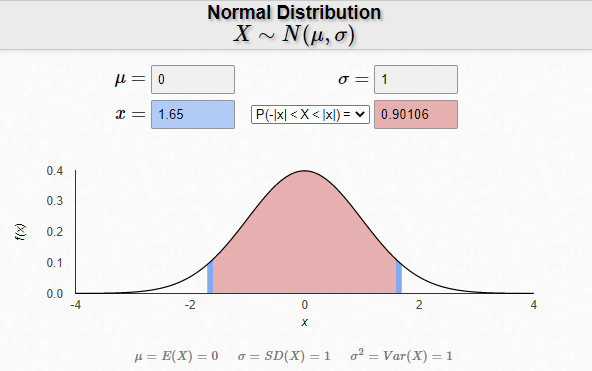

In [15]:
def calc_regression(x,y):
    res = stats.linregress(x.flatten(), y.flatten())
    a, b, r, p_value, std_err = res    
    return [a, b, r, p_value, std_err]


def extract_xy(df : pd.DataFrame, x_name : str , y_name : str, order_by : str,return_label=False):
    idx_notna = (df[x_name].notna()) &  (df[y_name].notna())
    ordered_notna = df[idx_notna].sort_values(by = order_by)
    x = ordered_notna[x_name]
    y = ordered_notna[y_name]
    if return_label:
        extract_xy.labels = ordered_notna[return_label]
    try:
        x = x.dt.days.to_numpy()
        y = y.dt.days.to_numpy()
    except:
        pass
    xy = np.zeros((2,x.shape[0]))
    xy[0] = x
    xy[1] = y
    return xy

        
def coeff_matrix():
    dic = {}
    for comercializacao, inner_dict_1 in coeffs.items():
        for SigTipoGeracao, inner_dict_2 in inner_dict_1.items():
            for atraso,inner_dict_3 in inner_dict_2.items():
                for coeff, value in inner_dict_3.items():
                    try:
                        dic[(comercializacao,coeff)][(SigTipoGeracao,atraso)] = value
                    except:
                        dic[(comercializacao,coeff)] = {}
                        dic[(comercializacao,coeff)][(SigTipoGeracao,atraso)] = value
    return dic

def calc_regression(x,y):
    res = stats.linregress(x.flatten(), y.flatten())
    a, b, r, p_value, std_err = res    
    return [a, b, r, p_value, std_err]


def extract_xy(df : pd.DataFrame, x_name : str , y_name : str, order_by : str,return_label=False):
    idx_notna = (df[x_name].notna()) &  (df[y_name].notna())
    ordered_notna = df[idx_notna].sort_values(by = order_by)
    x = ordered_notna[x_name]
    y = ordered_notna[y_name]
    if return_label:
        extract_xy.labels = ordered_notna[return_label]
    try:
        x = x.dt.days.to_numpy()
        y = y.dt.days.to_numpy()
    except:
        pass
    xy = np.zeros((2,x.shape[0]))
    xy[0] = x
    xy[1] = y
    return xy

def coeff_matrix():
    dic = {}
    for comercializacao, inner_dict_1 in coeffs.items():
        for SigTipoGeracao, inner_dict_2 in inner_dict_1.items():
            for atraso,inner_dict_3 in inner_dict_2.items():
                for coeff, value in inner_dict_3.items():
                    try:
                        dic[(comercializacao,coeff)][(SigTipoGeracao,atraso)] = value
                    except:
                        dic[(comercializacao,coeff)] = {}
                        dic[(comercializacao,coeff)][(SigTipoGeracao,atraso)] = value
    return pd.DataFrame(dic)


def plot_graph(step):
    return 0 #descomentar para plotar
    if step =="init":
        plot_graph.fig, plot_graph.axes = plt.subplots(num_subplots,1,figsize=(10,num_subplots*7))
    if step == "plot":
        ax = plot_graph.axes[count]
        labels = extract_xy.labels.to_list()
        x_plot = np.linspace(x1.min()-10,x1.max()+10,100)
        [ax.annotate(labels[n],(x1[n],y1[n]),fontsize=1) for n in range(len(y1))] if SigTipoGeracao=="UHE" else 0
        ax.scatter(x2,y2,color="red",alpha=0.15,label="Outliers")
        ax.scatter(x3,y3,color="blue",alpha=0.15,label="Dados utilizados")
        ax.plot(x_plot,a*x_plot+b+1,color="green",label= f"RL: {a:.1f}x+{b:.1f}")
        ax.set_title(f"""\nTipo de geração: {SigTipoGeracao} Número total de usinas: {x1.shape[0]} - Usinas eliminadas: {x2.shape[0]} -\n\nCorrelação: = {r_str}  - Tempo até OC max: {tempo_max:.2f} meses""")
        ax.grid()
        #ax.plot(x_plot,x_plot-m,linewidth=2)
        ax.fill_between(x_plot,x_plot-tempo_max-m,x_plot+tempo_max-m,color="blue",alpha=0.15,label="Área de não exclusão")
        ax.fill_between(x_plot,x_plot-tempo_max-m,y1.min(),color="red",alpha=0.15,label="Área de exclusão")
        ax.fill_between(x_plot,x_plot+tempo_max-m,y1.max(),color="red",alpha=0.15)
        ax.set_xlim(x1.min(),x1.max())
        ax.set_ylim(y1.min(),y1.max())
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_xlabel(f"{nome_coluna} (meses)")
        ax.set_ylabel(f"Atraso (meses)")
    if step == "save":
        plt.tight_layout()
        plt.savefig(f"correlacao_marcos_{comercializacao}.pdf")
        plt.show()
        plt.close()
        

In [16]:
z_score_max = 1.65
num_subplots = (len(tipos_geracao))*(len(lista_colunas_atrasos))
coeffs = {"ACR":{},"Fora do ACR":{},"Ambos":{}}
lista_colunas_coeffs = []
lista_colunas_prev_OC = []

for comercializacao in ["ACR","Fora do ACR","Ambos"]:
    print(comercializacao)
    plot_graph(step="init")
    matrix_pearson = {}
    count = -1
    for i,SigTipoGeracao in enumerate(tipos_geracao):
        matrix_pearson[SigTipoGeracao] = []
        coeffs[comercializacao][SigTipoGeracao] = {}
        for fase, marco in dict_fase_marco.items():      #fase in lista_colunas_atrasos:
            coeffs[comercializacao][SigTipoGeracao][fase] = {}
            count+=1            
            try:
                # Máscara com apenas indices que correspondem ao tipo geração especificado
                mask_geracao = (atraso_usina.SigTipoGeracao == SigTipoGeracao )
                if comercializacao != "Ambos":                  
                    mask_geracao &=  (atraso_usina.DscComercializacaoEnergia==comercializacao)
                # Todos pares x,y para o tipo geracao tal que: x = Atraso y = Atraso do marco especificado
                x1,y1 =  extract_xy(atraso_usina[mask_geracao], f"{marco}_atraso", "Atraso", f"{marco}_atraso",return_label="IdeUsinaOutorga")/30
                m = dict_tempo_fase_mean_std[SigTipoGeracao][f"{fase}_media"]
                std = dict_tempo_fase_mean_std[SigTipoGeracao][f"{fase}_std"]
                tempo_max = (z_score_max*std)+m
                outliers = ((tempo_construcao_por_usina[fase]) > tempo_max)| ((tempo_construcao_por_usina[fase]) < -tempo_max)
                x2,y2 = extract_xy(atraso_usina[mask_geracao & outliers], f"{marco}_atraso", "Atraso", f"{marco}_atraso")/30
                x3,y3 = extract_xy(atraso_usina[mask_geracao & ~outliers], f"{marco}_atraso", "Atraso", f"{marco}_atraso")/30
                a, b, r, p_value, std_err = calc_regression(x3,y3)
                coeffs[comercializacao][SigTipoGeracao][fase]["a"] = a
                coeffs[comercializacao][SigTipoGeracao][fase]["b"] = b
                r_str = f"{100*r:.1f}%"
                # Converte para meses
                tempo_max = tempo_max.days/30
                m = m.days/30
                std = std.days/30
                plot_graph(step="plot")
                calc.loc[mask_geracao, f"{marco}_atraso_a"] = a
                calc.loc[mask_geracao, f"{marco}_atraso_b"] = b
                tempo_fase_prev = (calc[f"{marco}_atraso"] * calc.loc[mask_geracao, f"{marco}_atraso_a"] )+ (calc.loc[mask_geracao, f"{marco}_atraso_b"]*pd.to_timedelta(1,'D'))
                calc.loc[mask_geracao,f"{marco}_Prev_OC"] =  calc["DatUGInicioOpComerOutorgado"] + tempo_fase_prev       #calc[marco] + tempo_fase_prev
                matrix_pearson[SigTipoGeracao].append(r_str)
                lista_colunas_coeffs.append(f"{marco}_atraso_a")
                lista_colunas_coeffs.append(f"{marco}_atraso_b")
                
            except (ValueError,AttributeError) as error:
                print(rf"Não foi possível calcular: {fase} para {SigTipoGeracao}: {error}")
                matrix_pearson[SigTipoGeracao].append("-")
    matrix_pearson =  pd.DataFrame(matrix_pearson,lista_colunas_atrasos)
    display(matrix_pearson.T)
    plot_graph(step="save")

matrix_pearson =  pd.DataFrame(matrix_pearson,lista_colunas_atrasos)
coeffs =  coeff_matrix()
display(coeffs)
lista_colunas_coeffs = list(set(lista_colunas_coeffs))

ACR
Não foi possível calcular: CC_OC para UTE: Inputs must not be empty.
Não foi possível calcular: CC_OC para UFV: Inputs must not be empty.


,DatInicioObraRealizado_atraso,DatConcretagemRealizado_atraso,DatMontagemRealizado_atraso,DatLiberacaoSFGTeste_atraso
UHE,91.2%,92.4%,21.6%,99.9%
UTE,92.5%,-,95.9%,99.9%
PCH,96.4%,97.6%,98.9%,99.9%
CGH,68.0%,93.9%,95.6%,99.9%
EOL,94.8%,95.1%,97.2%,99.9%
UFV,95.1%,-,95.3%,99.7%


Fora do ACR
Não foi possível calcular: CC_OC para UTE: Inputs must not be empty.


C:\Users\viniciusbarros\AppData\Local\Continuum\anaconda3\envs\aneel\lib\site-packages\scipy\stats\_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
C:\Users\viniciusbarros\AppData\Local\Continuum\anaconda3\envs\aneel\lib\site-packages\scipy\stats\_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\viniciusbarros\AppData\Local\Continuum\anaconda3\envs\aneel\lib\site-packages\scipy\stats\_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


Não foi possível calcular: CC_OC para UFV: Inputs must not be empty.


,DatInicioObraRealizado_atraso,DatConcretagemRealizado_atraso,DatMontagemRealizado_atraso,DatLiberacaoSFGTeste_atraso
UHE,0.0%,0.0%,0.0%,100.0%
UTE,92.9%,-,93.7%,99.8%
PCH,97.3%,98.1%,98.9%,100.0%
CGH,68.1%,92.4%,95.1%,99.8%
EOL,64.3%,70.3%,88.6%,99.7%
UFV,92.3%,-,90.3%,99.0%


Ambos
Não foi possível calcular: CC_OC para UTE: Inputs must not be empty.
Não foi possível calcular: CC_OC para UFV: Inputs must not be empty.


,DatInicioObraRealizado_atraso,DatConcretagemRealizado_atraso,DatMontagemRealizado_atraso,DatLiberacaoSFGTeste_atraso
UHE,90.9%,91.9%,26.6%,99.9%
UTE,93.0%,-,95.7%,99.9%
PCH,97.8%,98.5%,99.1%,100.0%
CGH,69.4%,92.7%,95.4%,99.9%
EOL,92.9%,93.5%,96.4%,99.9%
UFV,95.0%,-,94.7%,99.6%


ACR           Fora do ACR               Ambos          
                  a         b           a         b         a         b
UHE IO_OC  0.884466 -0.645467         NaN       NaN  0.882361 -0.920988
    CC_OC  0.877030 -0.485034         NaN       NaN  0.874614 -0.938483
    ME_OC  0.120430 -0.041846         NaN       NaN  0.134250  0.016123
    OT_OC  0.995159 -0.143144    1.014839 -0.225835  1.005973 -0.209616
UTE IO_OC  0.983057 -2.604298    0.991516 -1.329433  0.978421 -1.959614
    ME_OC  1.019189 -3.130767    1.057989 -2.450777  1.021283 -2.900791
    OT_OC  1.026837 -1.123707    1.008705 -0.622286  1.016230 -0.845200
PCH IO_OC  0.901681 -1.918159    1.034602 -2.713490  1.008864 -1.863673
    CC_OC  0.960748 -1.883686    0.997998 -1.750036  0.992264 -1.709608
    ME_OC  0.944054 -1.711382    1.008386 -0.436171  1.006907 -0.956450
    OT_OC  0.999826 -0.530715    0.995637 -0.211297  0.998491 -0.392109
CGH IO_OC  0.720305 -2.344350    0.814833  1.907017  0.816011  0.514857
    CC_OC  0.831829 -3.037371    1.042379 -1.814302  1.005934 -1.954373
    ME_OC  0.896275 -2.964376    1.041629 -1.751466  1.021932 -1.904517
    OT_OC  1.015766 -1.039878    1.017706 -0.493874  1.021266 -0.671932
EOL IO_OC  0.978787 -1.595049    0.654354 -1.476371  0.957761 -1.696734
    CC_OC  1.004386 -1.700567    0.740940 -2.646118  0.981918 -2.106730
    ME_OC  1.071556 -1.178996    0.883170 -3.668688  1.046178 -2.310022
    OT_OC  1.003037 -0.155329    0.996478 -0.101681  1.002646 -0.142347
UFV IO_OC  0.879728 -0.312676    0.922837 -0.430391  0.884943 -0.363174
    ME_OC  0.982004 -0.670440    0.819016 -0.784547  0.950301 -0.534555
    OT_OC  0.981642 -0.343965    1.001883 -0.146615  0.982444 -0.326938

In [17]:
lista_colunas_prev_OC = [f"{marco}_Prev_OC" for marco in dict_marco_nome]
lista_colunas_prev_OC_diff = [f"{marco}_Prev_OC_diff" for marco in dict_marco_nome]

for diff,prev in zip(lista_colunas_prev_OC_diff,lista_colunas_prev_OC):
    calc.loc[:,diff] = calc.DatLiberOpComerRealizado - calc[prev]

In [25]:
calc[lista_colunas_basic_info + lista_colunas_prev_OC_diff + ["DatLiberOpComerRealizado","Outlier"]].sample(15)

,IdeUsinaOutorga,SigTipoGeracao,origem,DscComercializacaoEnergia,DatInicioObraRealizado_Prev_OC_diff,DatConcretagemRealizado_Prev_OC_diff,DatMontagemRealizado_Prev_OC_diff,DatLiberacaoSFGTeste_Prev_OC_diff,DatLiberOpComerRealizado,Outlier
idx,,,,,,,,,,
3725,36974,EOL,skate,ACR,-361 days +16:23:41.783520393,-373 days +13:44:48.500791556,-188 days +06:58:59.036208674,-10 days +22:49:00.882792685,2020-02-29,False
1149,30656,EOL,bdworgs,Fora do ACR,86 days 10:13:56.919286177,118 days 02:52:41.197345688,-195 days +11:38:54.368817714,-18 days +19:59:49.432880813,2014-04-01,False
184,28219,UTE,bdworgs,ACR,-13 days +17:58:56.732481582,NaT,-28 days +16:16:29.829826056,-7 days +08:03:12.456175725,2016-04-30,False
2072,33680,EOL,bdworgs,ACR,-125 days +05:20:34.841162758,-199 days +05:05:53.269423689,NaT,7 days 17:24:21.339491989,2017-07-07,False
2272,35725,UTE,bdworgs,ACR,-473 days +18:55:37.102421766,NaT,-354 days +18:10:25.650991636,-66 days +07:57:03.049360251,2017-02-02,False
622,29707,UHE,bdworgs,ACR,-62 days +04:23:46.043563085,-82 days +19:39:49.723304838,-193 days +15:12:05.647898355,80 days 19:16:44.365688327,2012-03-29,True
411,29059,PCH,bdworgs,Fora do ACR,363 days 08:40:12.317967680,173 days 05:38:08.263143285,138 days 15:58:47.250309162,-34 days +10:22:51.245864402,2009-11-14,False
1008,30407,CGH,bdworgs,Fora do ACR,92 days 19:27:56.215881916,236 days 06:58:23.050355219,146 days 04:53:09.060969098,-33 days +10:07:29.549476175,2014-11-20,False
2380,27385,UTE,skate,ACR,-92 days +04:09:50.614363134,NaT,-326 days +18:47:08.208525700,-48 days +22:18:54.587192861,2021-04-15,False


In [31]:
a = [1,2,3]
b = [4,5,6]

In [34]:
list(chain.from_iterable(zip(a,b)))

[1, 4, 2, 5, 3, 6]

In [35]:
calc

,IdeUsinaOutorga,SigTipoGeracao,origem,DscComercializacaoEnergia,DatInicioObraRealizado,DatConcretagemRealizado,DatMontagemRealizado,DatLiberacaoSFGTeste,DatLiberOpComerRealizado,DatUGInicioOpComerOutorgado,IO_OC,CC_OC,ME_OC,OT_OC,Atraso,Outlier,IO_OC_media,IO_OC_std,CC_OC_media,CC_OC_std,ME_OC_media,ME_OC_std,OT_OC_media,OT_OC_std,DatInicioObraRealizado_estimado,DatConcretagemRealizado_estimado,DatMontagemRealizado_estimado,DatLiberacaoSFGTeste_estimado,DatInicioObraRealizado_atraso,DatConcretagemRealizado_atraso,DatMontagemRealizado_atraso,DatLiberacaoSFGTeste_atraso,DatInicioObraRealizado_atraso_a,DatInicioObraRealizado_atraso_b,DatInicioObraRealizado_Prev_OC,DatConcretagemRealizado_atraso_a,DatConcretagemRealizado_atraso_b,DatConcretagemRealizado_Prev_OC,DatMontagemRealizado_atraso_a,DatMontagemRealizado_atraso_b,DatMontagemRealizado_Prev_OC,DatLiberacaoSFGTeste_atraso_a,DatLiberacaoSFGTeste_atraso_b,DatLiberacaoSFGTeste_Prev_OC,DatInicioObraRealizado_Prev_OC_diff,DatConcretagemRealizado_Prev_OC_diff,DatMontagemRealizado_Prev_OC_diff,DatLiberacaoSFGTeste_Prev_OC_diff
idx,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,12,UHE,bdworgs,ACR,2004-10-15,2006-08-23,NaT,2008-12-17,2008-12-25,2007-03-01,1532 days,855 days,NaT,8 days,665 days,False,1329 days 04:06:51.428571424,349 days 21:35:18.717396480,1044 days 11:33:20,361 days 06:13:57.614526004,701 days 22:17:08.571428568,315 days 15:29:50.854045748,38 days 08:25:56.756756757,26 days 12:10:08.180316625,2003-07-10 19:53:08.571428576,2004-04-20 12:26:40.000000000,2005-03-29 01:42:51.428571432,2007-01-21 15:34:03.243243243,462 days 04:06:51.428571424,854 days 11:33:20,NaT,695 days 08:25:56.756756757,0.882361,-0.920988,2008-04-10 21:08:42.566682541,0.874614,-0.938483,2009-03-16 09:39:41.149202430,0.134250,0.016123,NaT,1.005973,-0.209616,2009-01-28 07:04:40.605168493,258 days 02:51:17.433317459,-82 days +14:20:18.850797570,NaT,-35 days +16:55:19.394831507
2,19,UTE,bdworgs,Fora do ACR,2006-09-15,NaT,NaT,2008-04-12,2008-04-18,2002-01-01,581 days,NaT,NaT,6 days,2299 days,False,564 days 01:09:07.200000,346 days 12:43:20.612984556,NaT,NaT,407 days 07:49:05.454545456,320 days 06:38:25.702877648,73 days 03:33:20,77 days 21:07:43.950181564,2000-06-15 22:50:52.800000000,NaT,2000-11-19 16:10:54.545454544,2001-10-19 20:26:40.000000000,2282 days 01:09:07.200000,NaT,NaT,2366 days 03:33:20,0.978421,-1.959614,2008-02-09 20:14:25.897799370,NaN,NaN,NaT,1.021283,-2.900791,NaT,1.016230,-0.845200,2008-07-31 16:57:39.231396283,68 days 03:45:34.102200630,NaT,NaT,-105 days +07:02:20.768603717
3,42,UHE,bdworgs,ACR,2001-05-31,NaT,NaT,2005-07-20,2005-07-30,2003-11-30,1521 days,NaT,NaT,10 days,608 days,False,1329 days 04:06:51.428571424,349 days 21:35:18.717396480,1044 days 11:33:20,361 days 06:13:57.614526004,701 days 22:17:08.571428568,315 days 15:29:50.854045748,38 days 08:25:56.756756757,26 days 12:10:08.180316625,2000-04-09 19:53:08.571428576,2001-01-19 12:26:40.000000000,2001-12-28 01:42:51.428571432,2003-10-22 15:34:03.243243243,416 days 04:06:51.428571424,NaT,NaT,636 days 08:25:56.756756757,0.882361,-0.920988,2004-11-30 07:01:07.073282689,0.874614,-0.938483,NaT,0.134250,0.016123,NaT,1.005973,-0.209616,2005-08-30 22:37:13.775314861,241 days 16:58:52.926717311,NaT,NaT,-32 days +01:22:46.224685139
6,127,UTE,bdworgs,Fora do ACR,2000-10-18,NaT,NaT,NaT,2002-05-02,2002-04-17,561 days,NaT,NaT,NaT,15 days,False,564 days 01:09:07.200000,346 days 12:43:20.612984556,NaT,NaT,407 days 07:49:05.454545456,320 days 06:38:25.702877648,73 days 03:33:20,77 days 21:07:43.950181564,2000-09-29 22:50:52.800000000,NaT,2001-03-05 16:10:54.545454544,2002-02-02 20:26:40.000000000,18 days 01:09:07.200000,NaT,NaT,NaT,0.978421,-1.959614,2002-05-02 16:46:26.936887864,NaN,NaN,NaT,1.021283,-2.900791,NaT,1.016230,-0.845200,NaT,-1 days +07:13:33.063112136,NaT,NaT,NaT
7,161,PCH,bdworgs,Fora do ACR,2006-06-01,2007-09-30,NaT,2009-06-30,2009-08-07,2003-05-01,1163 days,677 days,NaT,38 days,2290 days,False,802 days 04:45:20.737327192,273 d